# iLykei Lecture Series
# Advanced Machine Learning and Artificial Intelligence (MScA 32017)

# Project: Detection of Toxic Comments Online

## Notebook 2: Data Overview

## Yuri Balasanov, Leonid Nazarov, &copy; iLykei 2018


# Introduction
[Jigsaw's Toxic Comment ClassificationChallenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge), organized by Kaggle and [Jigsaw](https://jigsaw.google.com/) attracted more than 4500 teams and appeared the third most popular featured contest in Kaggle history. The goal of the competition was to identify and classify toxic online comments.  

As Kaggle puts it, "The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. Discussing things we care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut user comments". 

# Data overview

Train and test data can be found on the [data page](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data). Log in to kaggle.com web site and download files:

`train.csv`, `test.csv`, `test_labels.csv`.

Look at the data structure.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import os
from os.path import expanduser

dataPath = expanduser("~/Datasets/32017/jigsaw-toxic-comments/")

train = pd.read_csv(dataPath + 'train.csv',index_col=0)
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


The data contain columns of id, text comment and 6 columns of class indicators which are the target variables.

The target variables are the following types of toxicity:

In [2]:
types = list(train)[1:]
print(types)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


Comments can belong to several classes simultaneously. The following figure shows frequences of the classes in the train set.

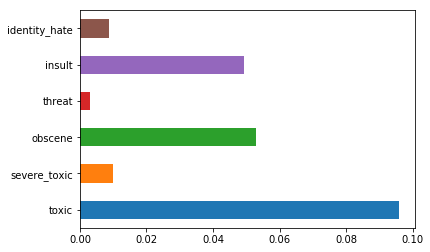

In [3]:
train[types].mean().plot(kind='barh')

The number of "clean" comments is

In [4]:
nb_clean = (train[types].sum(axis=1)==0).sum()
print('clean:',nb_clean,'(',round(100*nb_clean/len(train),2),'% )')

clean: 143346 ( 89.83 % )


Some examples of toxic comments.

In [5]:
for t in types:
    print('\n','*'*10+(t+' comments').upper()+'*'*10,'\n')
    for c in train.comment_text[train[t]==1][:3]:
        print(c)
        print('---- comment end ----')


 **********TOXIC COMMENTS********** 

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
---- comment end ----
Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...
---- comment end ----
Bye! 

Don't look, come or think of comming back! Tosser.
---- comment end ----

 **********SEVERE_TOXIC COMMENTS********** 

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
---- comment end ----
Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell!
---- comment end ----
you are a stupid fuck 

and your mother's cunt stinks
---- comment end ----

 **********OBSCENE COMMENTS********** 

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
---- comment end ----
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Gr

# Test labels disclosure

Soon after closing the competition Kaggle added test data labels to the Data Page. Usually this information is not provided, but in this case Jigsaw have asked to provide it to community for continued model improvements and research. 
Some of the test samples were not labelled and were not used for scoring. Value of -1 indicates them. 

Remove labelled samples from the test set and add them to the train set. 

In [6]:
test = pd.read_csv(dataPath+'test.csv',index_col=0)
test_labels = pd.read_csv(dataPath+'test_labels.csv',index_col=0)
print(test_labels.head())
labelled_test = test.join(test_labels)
disclosed = labelled_test.toxic>-1
print(disclosed .mean(),'% of test is labelled')
train = train.append(labelled_test[disclosed])
test = labelled_test[~disclosed][['comment_text']]
print(train.shape,test.shape)
train.to_csv(dataPath+'tc_train.csv')
test.to_csv(dataPath+'tc_test.csv')

                  toxic  severe_toxic  obscene  threat  insult  identity_hate
id                                                                           
00001cee341fdb12     -1            -1       -1      -1      -1             -1
0000247867823ef7     -1            -1       -1      -1      -1             -1
00013b17ad220c46     -1            -1       -1      -1      -1             -1
00017563c3f7919a     -1            -1       -1      -1      -1             -1
00017695ad8997eb     -1            -1       -1      -1      -1             -1
0.41770912224804785 % of test is labelled
(223549, 7) (89186, 1)


Show frequences of the classes after modification.

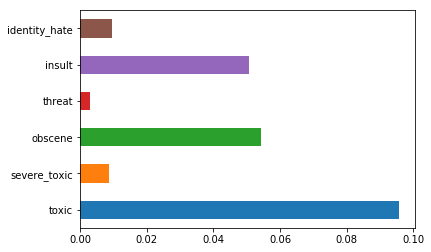

In [7]:
train[types].mean().plot(kind='barh')

Distribution of classes on the new train set if close to that on the initial set.

# Words Polarity Analysis

Before any advanced models are trained look at words that likely identify classes.

The idea of this very simple words polarity analysis based on logistic regression coefficients was suggested by [SerMakarevich](https://www.kaggle.com/sermakarevich). It consists of two steps:
- create tf-idf features for words from train data set comments;
- fit logistic regression model taking these features as regressors and class  labels as target variable.

The word regression coefficient can be considered as a polarity measure for given toxicity type.  

Perfrom this analysis for toxicity type `severe_toxic`. 

In [8]:
tox_type = 'severe_toxic'

<font color=blue>
    
**Assignment** <br>
Create tf-idf features for words from train data set comments with the following settings: max_features=50000, min_df=5, max_df=0.9.
Use instructions from [MScA_32017_AMLAI_TC1_NLP_Basics.ipynb](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FToxicComments%2FMScA_32017_AMLAI_TC1_NLP_Basics.ipynb)

In [9]:
# Skipped code
# Extract tf-idf features


In [10]:
# Skipped code
# Extract tf-idf features

# Remove

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=50000, min_df=5, max_df=0.9)
X = tfidf.fit_transform(train.comment_text)

<font color=blue>

Fit logistic regression model taking these features as regressors and 'severe_toxic' class  labels as target variable.

In [11]:
# Skipped code
# Fit logistic regression using tf-idf features X and train[tox_type].values as response


In [12]:
# Skipped code
# Fit logistic regression using tf-idf features X and train[tox_type].values as response

# Remove
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X, train[tox_type].values)

/Users/rowena/miniconda3/envs/msca/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

<font color=blue>

Make data frame `polarity` with index containing all words from `vocabulary_.keys()` of `TfidfVectorizer`  and having two columns: first of them contains the corresponding  `vocabulary_.values()`, the second - logistic regression coefficients.

In [13]:
# Skipped code
# Create data frame polarity



In [14]:
# Skipped code
# Create data frame polarity

polarity = pd.DataFrame.from_dict(tfidf.vocabulary_,orient='index')\
                                                    .sort_values(0)
polarity['coef'] = lr.coef_[0]

print(polarity.shape)
print(list(polarity.columns))
print(polarity['coef'][:10])

(44930, 2)
[0, 'coef']
00        0.081051
000      -0.158614
0000     -0.009370
000000   -0.017538
0000z    -0.008223
0001     -0.004987
000th    -0.004818
001      -0.009690
002      -0.001352
003      -0.003467
Name: coef, dtype: float64


Sort data frame `polarity` according to coefficients values. Find 30 words with maximal coefficients and 30 words with minimal coefficients. Plot their coefficients with horizontal bars.

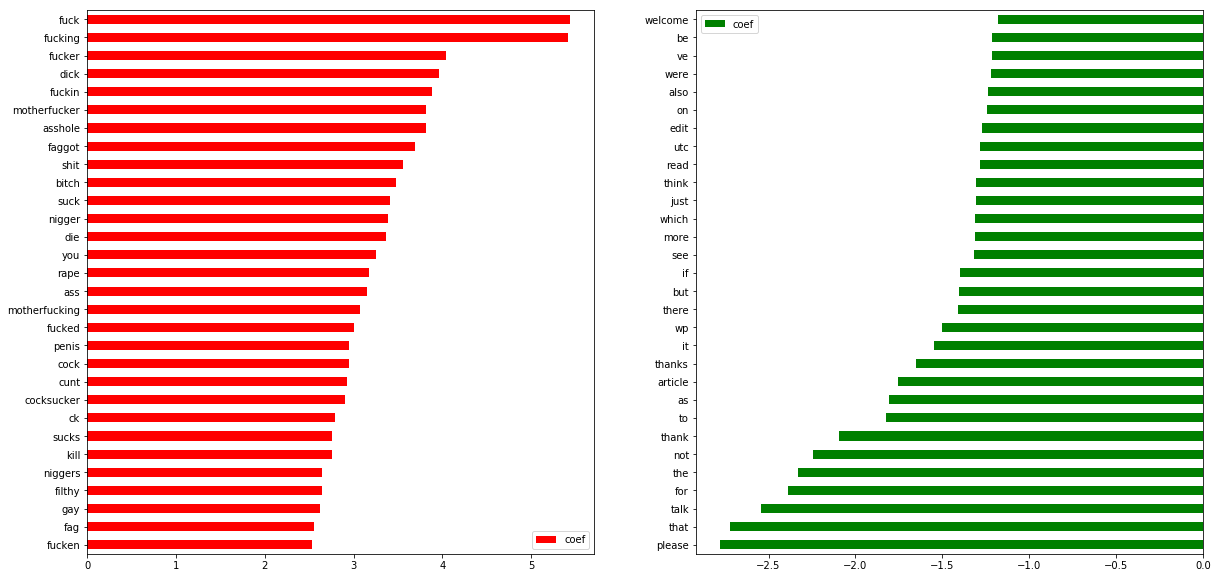

In [15]:
polarity.sort_values('coef',inplace=True)
plt.figure(figsize=(20, 10))
ax = plt.subplot(1,2,1)
polarity[['coef']].tail(30).plot(kind='barh', color='red', ax=ax)
ax = plt.subplot(1,2,2)
polarity[['coef']].head(30).plot(kind='barh', color='green', ax=ax)